## Importing necessary packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from datetime import date
import seaborn as sns
from pydataset import data
from env import host, user, password
import os
import copy
from sklearn.feature_selection import SelectKBest, f_regression
import sklearn.preprocessing
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoLars
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings("ignore")
from acquire import get_zillow_data
from prep import prep, prep_model

## Acquiring data

In [2]:
zillow = get_zillow_data()

## Prepping the data

In [3]:
# Adding in the age of the home, dropping the features used to select the specific data, putting in county names,
# creating tax rate feature, getting rid of outliers in taxvaluedollarcnt and lotsizesquarefeet using typical
# IQR * 1.5 method

zillow_no_out = prep(zillow)

In [4]:
# Splitting into train, test, and validate

train, test = train_test_split(zillow_no_out, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)

## Explore

In [5]:
train

,taxamount,lotsizesquarefeet,county,taxvaluedollarcnt,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,age,tax_rate
3272,823.63,7502.0,Los Angeles,45507.0,864.0,1.0,2.0,70.0,1.809897
2899,4326.04,5849.0,Los Angeles,350697.0,1584.0,2.0,3.0,98.0,1.233555
8542,1315.74,7200.0,Orange,132879.0,1309.0,2.0,3.0,49.0,0.990179
20649,8671.24,5208.0,Los Angeles,663216.0,2978.0,3.0,5.0,17.0,1.307453
9307,7463.74,8047.0,Orange,619056.0,2710.0,3.0,3.0,19.0,1.205665
...,...,...,...,...,...,...,...,...,...
6982,5713.50,6240.0,Orange,479778.0,1434.0,2.0,4.0,58.0,1.190863
11306,3190.23,7800.0,Los Angeles,262475.0,1158.0,1.0,3.0,75.0,1.215441
4927,6637.67,7565.0,Los Angeles,579063.0,1819.0,2.0,3.0,67.0,1.146278
31069,6234.64,7344.0,Orange,610266.0,1875.0,3.0,3.0,54.0,1.021627


In [6]:
# Counts of each county

train.groupby('county').count()

,taxamount,lotsizesquarefeet,taxvaluedollarcnt,calculatedfinishedsquarefeet,bathroomcnt,bedroomcnt,age,tax_rate
county,,,,,,,,
Los Angeles,9004,9004,9004,9004,9004,9004,9004,9004
Orange,3309,3309,3309,3309,3309,3309,3309,3309
Ventura,683,683,683,683,683,683,683,683


<AxesSubplot:>

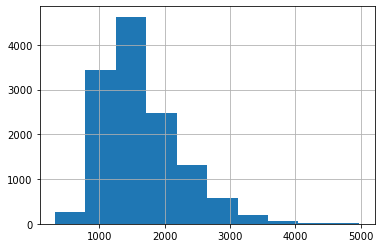

In [7]:
# Histogram of square foot breakdown

train.calculatedfinishedsquarefeet.hist()

<AxesSubplot:>

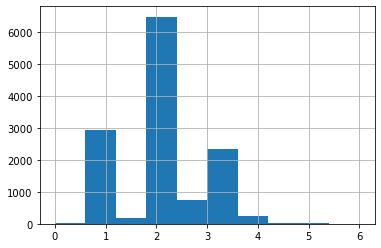

In [8]:
# Histogram of bathroom counts

train.bathroomcnt.hist()

<AxesSubplot:>

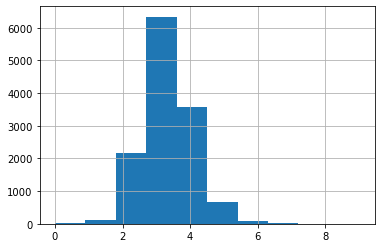

In [9]:
# Histogram of bedroom counts

train.bedroomcnt.hist()

<AxesSubplot:>

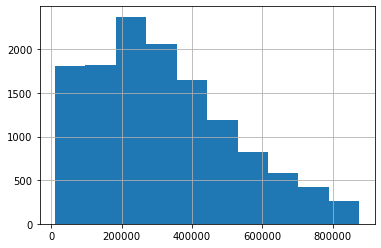

In [10]:
# Histogram of property values

train.taxvaluedollarcnt.hist()

<AxesSubplot:xlabel='taxvaluedollarcnt'>

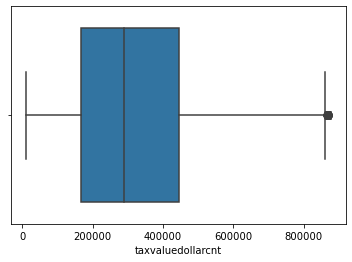

In [11]:
# Boxplot of property values

sns.boxplot(train.taxvaluedollarcnt)

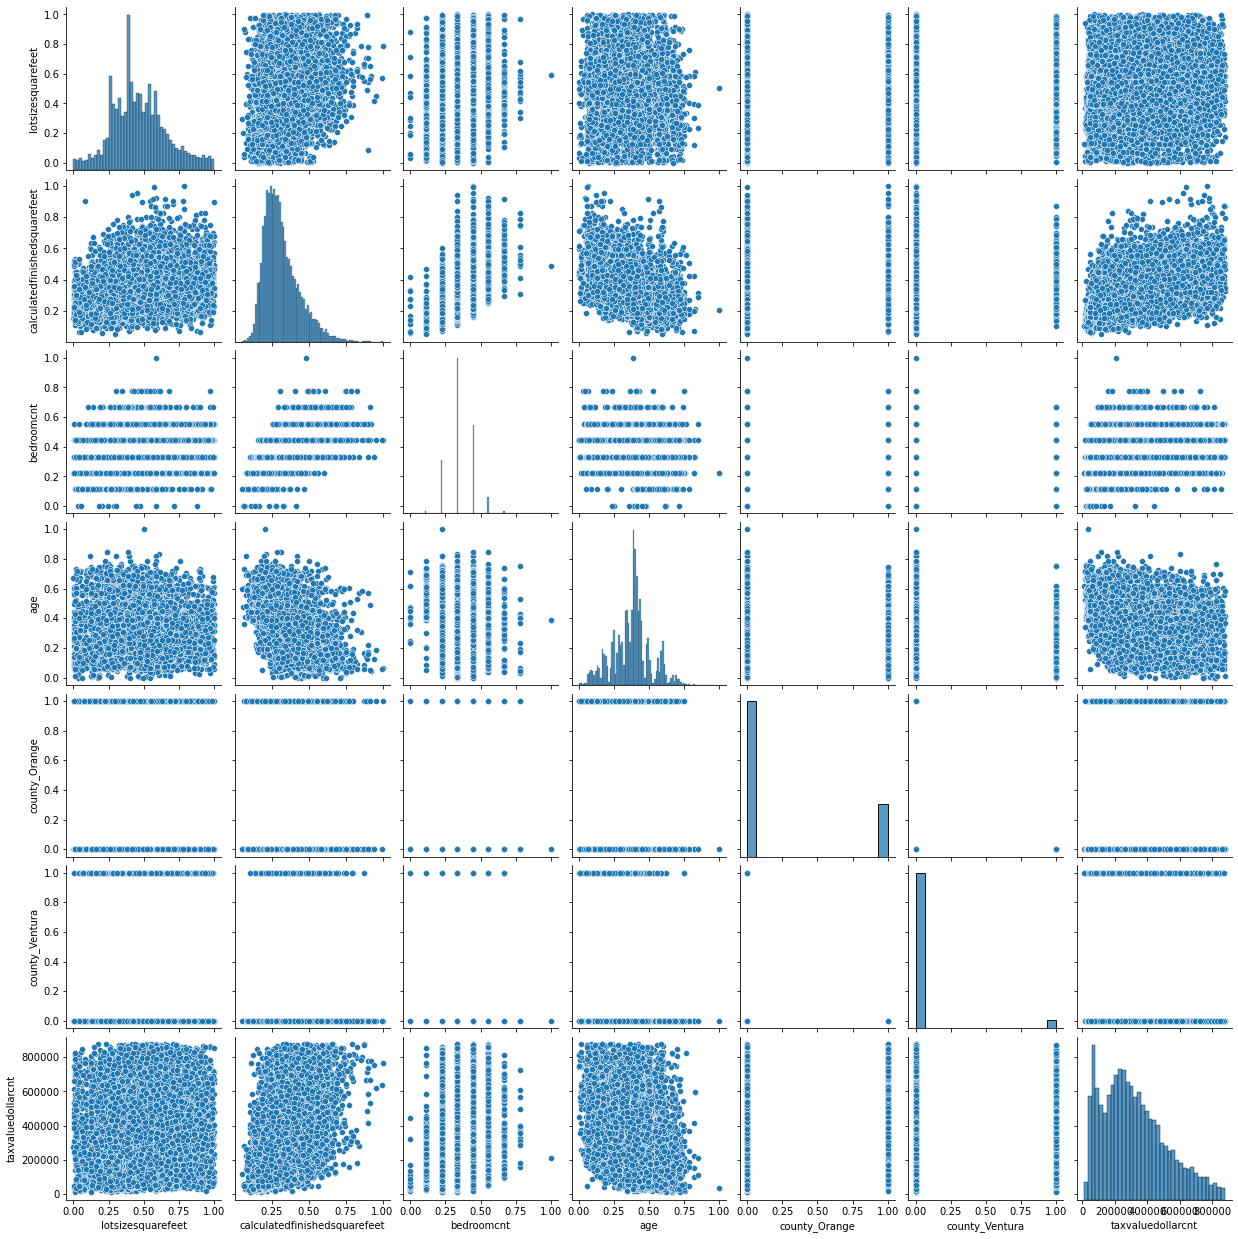

In [56]:
# Plotting all variables together

sns.pairplot(train)

<AxesSubplot:xlabel='bedroomcnt'>

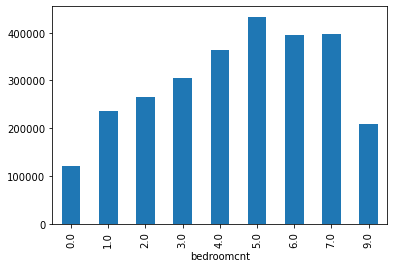

In [12]:
# Bar chart of bedroom counts

train.groupby('bedroomcnt').taxvaluedollarcnt.mean().plot.bar()

<AxesSubplot:xlabel='bathroomcnt'>

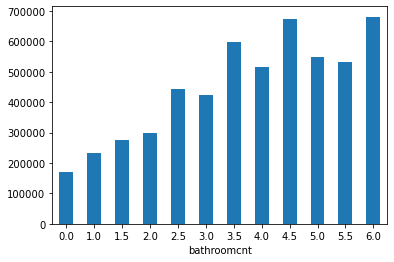

In [13]:
# Bar chart of bathroom counts

train.groupby('bathroomcnt').taxvaluedollarcnt.mean().plot.bar(rot = 0)

<AxesSubplot:xlabel='calculatedfinishedsquarefeet', ylabel='taxvaluedollarcnt'>

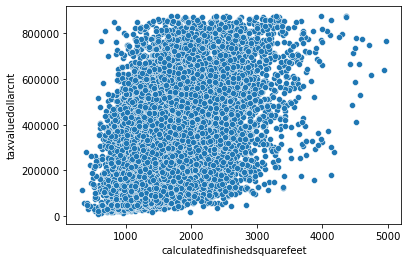

In [14]:
# Scatterplot of property square feet and property value

sns.scatterplot(x = 'calculatedfinishedsquarefeet', y = 'taxvaluedollarcnt', data = train)

In [15]:
# Rounding the property ages for better visualization

df = copy.deepcopy(train) 
rounder = df['age'].apply(lambda x: int(round(x, -1)))
df['age'] = rounder

<AxesSubplot:xlabel='age', ylabel='taxvaluedollarcnt'>

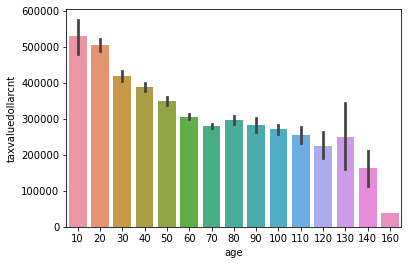

In [16]:
# Scatterplot of property age and property value

sns.barplot(x = 'age', y = 'taxvaluedollarcnt', data = df)

<AxesSubplot:xlabel='taxvaluedollarcnt', ylabel='Count'>

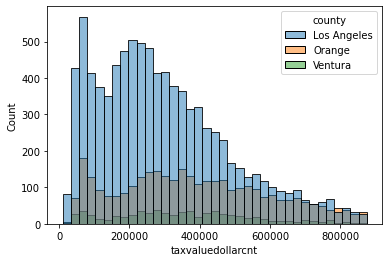

In [17]:
# Histogram of different counties property values

sns.histplot(data = train, x = "taxvaluedollarcnt", hue = "county")

<AxesSubplot:xlabel='county'>

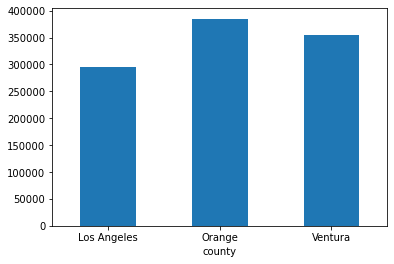

In [18]:
# Bar chart of average property value by county

train.groupby('county').taxvaluedollarcnt.mean().plot.bar(rot = 0)

In [28]:
la_county.taxvaluedollarcnt.mean(), o_county.taxvaluedollarcnt.mean(), vt_county.taxvaluedollarcnt.mean()

(294586.7438916037, 385030.3414928982, 354045.2576866764)

<AxesSubplot:xlabel='county'>

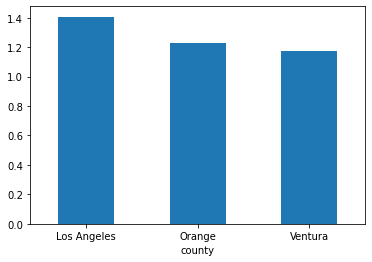

In [29]:
# Bar chart of average tax rate by county

train.groupby('county').tax_rate.mean().plot.bar(rot = 0)

In [20]:
# Splitting train data into subgroups by county

la_county = train[train['county'] == 'Los Angeles']
o_county = train[train['county'] == 'Orange']
vt_county = train[train['county'] == 'Ventura']
la_county.tax_rate.mean(), o_county.tax_rate.mean(), vt_county.tax_rate.mean()

(1.4068309222238957, 1.2298529820425286, 1.1758465871086916)

In [21]:
# Making subgroups by county minus the outliers for visualization

Q1 = train['tax_rate'].quantile(0.25)
Q3 = train['tax_rate'].quantile(0.75)
IQR = Q3 - Q1
zillow_taxrates = train[(train.tax_rate < (Q3 + IQR)) & (train.tax_rate > (Q1 - IQR))]
la_county_tax = zillow_taxrates[zillow_taxrates['county'] == 'Los Angeles']
o_county_tax = zillow_taxrates[zillow_taxrates['county'] == 'Orange']
vt_county_tax = zillow_taxrates[zillow_taxrates['county'] == 'Ventura']

In [22]:
zillow_no_out[zillow_no_out.tax_rate > (Q3 + IQR)].count()

taxamount                       3092
lotsizesquarefeet               3092
county                          3092
taxvaluedollarcnt               3092
calculatedfinishedsquarefeet    3092
bathroomcnt                     3092
bedroomcnt                      3092
age                             3092
tax_rate                        3092
dtype: int64

<AxesSubplot:xlabel='tax_rate', ylabel='Count'>

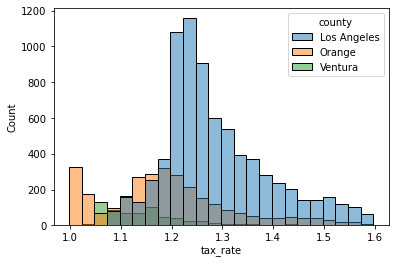

In [32]:
# Histogram of different counties tax rates

sns.histplot(data = zillow_taxrates, x = "tax_rate", hue = "county", binwidth = .025)

<AxesSubplot:xlabel='tax_rate', ylabel='Count'>

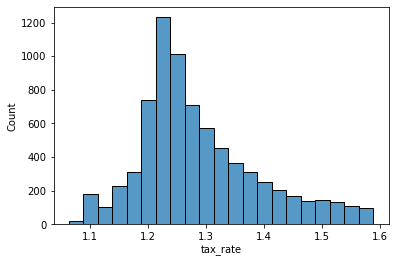

In [33]:
# Histogram of tax rates in Los Angeles county

sns.histplot(data = la_county_tax, x = "tax_rate", binwidth = .025)

<AxesSubplot:xlabel='tax_rate', ylabel='Count'>

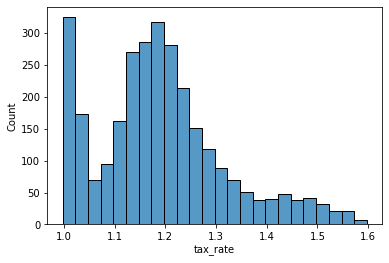

In [34]:
# Histogram of tax rates in Orange county

sns.histplot(data = o_county_tax, x = "tax_rate", binwidth = .025)

<AxesSubplot:xlabel='tax_rate', ylabel='Count'>

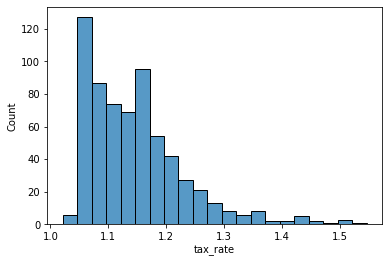

In [35]:
# Histogram of tax rates in Ventura county

sns.histplot(data = vt_county_tax, x = "tax_rate", binwidth = .025)

## Statistical tests

### Hypothesis 1

#### Null Hypothesis: There is no linear correlation between the square feet of a property and the tax value of that property

#### Alternative Hypothesis: There is a linear correlation between the square feet of a property and the tax value of that property

In [36]:
# Running a correlation test between property square feet and property value

corr, p = stats.pearsonr(train.taxvaluedollarcnt, train.calculatedfinishedsquarefeet)
corr, p

(0.43564309578325583, 0.0)

#### We reject the null hypothesis that there is no linear relationship between square feet of a property and the tax value of that property.

A bigger house correlating with a higher value doesn't come as much of a surprise, although the relationship is not as strong as I expected.

### Hypothesis 2

#### Null Hypothesis: There is no difference between Los Angeles county tax rate and the overall average county tax rates

#### Alternative Hypothesis:  There is a difference between Los Angeles county tax rate and the overall average county tax rates

<AxesSubplot:xlabel='tax_rate', ylabel='Density'>

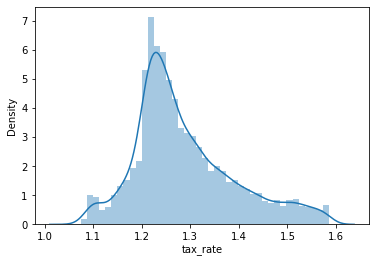

In [37]:
# Examining shape of LA county tax rates

sns.distplot(la_county_tax.tax_rate)

In [38]:
# Checking difference in median and mean tax rates

train.tax_rate.median(), train.tax_rate.mean()

(1.2540499405766408, 1.3496300677345237)

In [39]:
# T-test between LA tax rate and average tax rate

t, p = stats.ttest_1samp(la_county.tax_rate, zillow_no_out.tax_rate.mean())
t, p

(13.021842426464673, 2.0414671117267813e-38)

#### We reject the null hypothesis that there is no difference between Los Angeles county tax rate and the overall average county tax rates

As could have been guessed by the tax rate histogram, it seems the tax rate in Los Angeles is different than the average tax rate.

## Modeling

### Prepping again for modeling

In [40]:
# Dropping columns related to property value (because that's cheating), creating dummies, and scaling

zillow_minmax = prep_model(zillow_no_out)

In [41]:
# Splitting into train, test, and validate

train, test = train_test_split(zillow_minmax, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)

In [42]:
# Further splitting for models

x_train = train.drop(columns = ['taxvaluedollarcnt'])
y_train = train['taxvaluedollarcnt']

x_validate = validate.drop(columns = ['taxvaluedollarcnt'])
y_validate = validate['taxvaluedollarcnt']

x_test = test.drop(columns = ['taxvaluedollarcnt'])
y_test = test['taxvaluedollarcnt']

### Establishing a baseline

In [43]:
# Using average and median to predict property values to establish a baseline for my models

y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# Establishing mean
zillow_pred_mean = y_train['taxvaluedollarcnt'].mean()
y_train['zillow_pred_mean'] = zillow_pred_mean
y_validate['zillow_pred_mean'] = zillow_pred_mean

# Establishing median
zillow_pred_median = y_train['taxvaluedollarcnt'].median()
y_train['zillow_pred_median'] = zillow_pred_median
y_validate['zillow_pred_median'] = zillow_pred_median

# RMSE of mean
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.zillow_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.zillow_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of median
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.zillow_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.zillow_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  197936.54 
Validate/Out-of-Sample:  192742.8
RMSE using Median
Train/In-Sample:  200472.82 
Validate/Out-of-Sample:  195135.18


### Linear Regression

In [44]:
lin_reg = LinearRegression(normalize = True)
lin_reg.fit(x_train, y_train['taxvaluedollarcnt'])
y_train['value_pred_lm'] = lin_reg.predict(x_train)
rmse_train = mean_squared_error(y_train['taxvaluedollarcnt'], y_train.value_pred_lm)**(1/2)
y_validate['value_pred_lm'] = lin_reg.predict(x_validate)
rmse_validate = mean_squared_error(y_validate['taxvaluedollarcnt'], y_validate.value_pred_lm)**(1/2)
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train, 2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

RMSE for OLS using LinearRegression
Training/In-Sample:  176082.75 
Validation/Out-of-Sample:  173572.26


### LassoLars

In [45]:
lars = LassoLars(alpha=1.0)
lars.fit(x_train, y_train['taxvaluedollarcnt'])
y_train['value_pred_lars'] = lars.predict(x_train)
rmse_train = mean_squared_error(y_train['taxvaluedollarcnt'], y_train.value_pred_lars)**(1/2)
y_validate['value_pred_lars'] = lars.predict(x_validate)
rmse_validate = mean_squared_error(y_validate['taxvaluedollarcnt'], y_validate.value_pred_lars)**(1/2)
print("RMSE for Lasso + Lars\nTraining/In-Sample: ", round(rmse_train, 2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

RMSE for Lasso + Lars
Training/In-Sample:  176083.08 
Validation/Out-of-Sample:  173558.53


### TweedieRegressor(GLM)

In [46]:
glm = TweedieRegressor(power=1, alpha=0)
glm.fit(x_train, y_train['taxvaluedollarcnt'])
y_train['value_pred_glm'] = glm.predict(x_train)
rmse_train = mean_squared_error(y_train['taxvaluedollarcnt'], y_train.value_pred_glm)**(1/2)
y_validate['value_pred_glm'] = glm.predict(x_validate)
rmse_validate = mean_squared_error(y_validate['taxvaluedollarcnt'], y_validate.value_pred_glm)**(1/2)
print("RMSE for Tweedie Regressor\nTraining/In-Sample: ", round(rmse_train, 2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

RMSE for Tweedie Regressor
Training/In-Sample:  176813.11 
Validation/Out-of-Sample:  174006.99


### Polynomial Regression

In [47]:
pf = PolynomialFeatures(degree=2)
x_train_degree2 = pf.fit_transform(x_train)
x_validate_degree2 = pf.transform(x_validate)

In [48]:
lm2 = LinearRegression(normalize=True)
lm2.fit(x_train_degree2, y_train['taxvaluedollarcnt'])
y_train['value_pred_lm2'] = lm2.predict(x_train_degree2)
rmse_train = mean_squared_error(y_train['taxvaluedollarcnt'], y_train.value_pred_lm2)**(1/2)
y_validate['value_pred_lm2'] = lm2.predict(x_validate_degree2)
rmse_validate = mean_squared_error(y_validate['taxvaluedollarcnt'], y_validate.value_pred_lm2)**(1/2)
print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", round(rmse_train, 2), 
      "\nValidation/Out-of-Sample: ", round(rmse_validate, 2))

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  173337.22 
Validation/Out-of-Sample:  171167.25


## Feature Engineering

### SelectKBest

In [49]:
f_selector = SelectKBest(f_regression, k=4)
f_selector.fit(zillow_minmax.drop(columns = ['taxvaluedollarcnt']), zillow_minmax['taxvaluedollarcnt'])
feature_mask = f_selector.get_support()
f_feature = zillow_minmax.drop(columns = ['taxvaluedollarcnt']).iloc[:,feature_mask].columns.tolist()
f_feature

['calculatedfinishedsquarefeet', 'bedroomcnt', 'age', 'county_Orange']

### Recursive Feature Elimination

In [50]:
lm = LinearRegression()
rfe = RFE(lm, 4)
rfe.fit(zillow_minmax.drop(columns = ['taxvaluedollarcnt']), zillow_minmax['taxvaluedollarcnt'])
feature_mask_rfe = rfe.support_
rfe_feature = zillow_minmax.drop(columns = ['taxvaluedollarcnt']).iloc[:,feature_mask_rfe].columns.tolist()
rfe_feature

['calculatedfinishedsquarefeet', 'bedroomcnt', 'age', 'county_Orange']

# Test

In [51]:
# Since Polynomial Regression was my most successful model at predicting out of sample data, I'm going to use that 
# model on my test data

x_test_degree2 = pf.transform(x_test)
y_test = pd.DataFrame(y_test)
y_test['test_value_pred_lm2'] = lm2.predict(x_test_degree2)
rmse_test = mean_squared_error(y_test['taxvaluedollarcnt'], y_test.test_value_pred_lm2)**(1/2)

print("RMSE for Tweedie Regressor\nTest: ", round(rmse_test, 2))

RMSE for Tweedie Regressor
Test:  174668.49


# Data Dictionary

In [52]:
data_dictionary = pd.DataFrame(index = zillow.columns, columns=['type', 'description'])
for name in zillow_no_out.columns:
    data_dictionary.loc[name,'type'] = 'float64'

In [53]:
data_dictionary.loc[['county'], 'type'] = 'object'

In [54]:
data_dictionary.loc[['taxamount'], 'description'] = 'The annual taxes charged for the property'
data_dictionary.loc[['lotsizesquarefeet'], 'description'] = 'The total square feet of the lot the property is on'
data_dictionary.loc[['county'], 'description'] = 'The county the property is located in'
data_dictionary.loc[['taxvaluedollarcnt'], 'description'] = 'The total tax assessed value of the property'
data_dictionary.loc[['calculatedfinishedsquarefeet'], 'description'] = 'The total square feet of the developed property'
data_dictionary.loc[['bathroomcnt'], 'description'] = 'The number of bathrooms in the property'
data_dictionary.loc[['bedroomcnt'], 'description'] = 'The number of bedrroms in the property'
data_dictionary.loc[['age'], 'description'] = 'The age of the developed property'
data_dictionary.loc[['tax_rate'], 'description'] = 'The percentage of annual taxes to total tax assessed value of the property'

In [55]:
print(data_dictionary.to_markdown())

|                              | type    | description                                                                |
|:-----------------------------|:--------|:---------------------------------------------------------------------------|
| taxamount                    | nan     | The annual taxes charged for the property                                  |
| lotsizesquarefeet            | float64 | The total square feet of the lot the property is on                        |
| county                       | object  | The county the property is located in                                      |
| taxvaluedollarcnt            | float64 | The total tax assessed value of the property                               |
| calculatedfinishedsquarefeet | float64 | The total square feet of the developed property                            |
| bathroomcnt                  | nan     | The number of bathrooms in the property                                    |
| bedroomcnt                   | float64